# 1. Import libraries

In [248]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import json


In [16]:
input_shape=(256,256,3)


In [59]:
# def add_final_layers(base_model):
#     model = Sequential()
#     model.add(base_model)
#     model.add(layers.Flatten())
#     model.add(layers.Dense(10, activation="relu"))
#     model.add(layers.Reshape((-1,10)))
#     model.add(layers.SimpleRNN(units=10, activation="tanh", return_sequences=True))
#     model.add(layers.SimpleRNN(units=5, activation="tanh", return_sequences=True))
#     model.add(layers.Dense(20, activation="softmax"))
#     return model


# 2. Load MobileNet

### 1.1 MobileNet

In [183]:
def load_model():
    model = MobileNet(
        include_top=False,  # Exclude fully connected layers
        weights='imagenet',  # Use pre-trained weights
        input_shape=input_shape,  # Set your image input shape
        pooling='avg',  # Use default global average pooling
        classes=20,  # Adjust based on your task's number of classes
        classifier_activation='softmax'  # Softmax activation for classificatio
    )
    return model

model_mobilenet = load_model()
model_mobilenet.trainable = False


In [184]:
model_mobilenet.summary()
# model_mobilenet.layers


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                         

In [185]:
layers_outputs = [layer.output for layer in model_mobilenet.layers]
layers_outputs


[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv1')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv1_bn')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv1_relu')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv_dw_1')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv_dw_1_bn')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv_dw_1_relu')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv_pw_1')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv_pw_1_bn')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv_pw_1_relu')>,
 <KerasTensor: shape=(None, 129, 129, 64) dtype=float32 (created by layer 'conv_pad_2')>,
 <KerasTens

### 1.2 MobileNetv3Small

In [27]:
def load_model():
    model = MobileNetV3Small(
        include_top=False,  # Exclude fully connected layers
        weights='imagenet',  # Use pre-trained weights
        input_shape=input_shape,  # Set your image input shape
        pooling=None,  # Use default global average pooling
        classes=20,  # Adjust based on your task's number of classes
        classifier_activation='softmax'  # Softmax activation for classification
    )
    return model

model_mobilenetv3 = load_model()
model_mobilenetv3.trainable = False


4334752/4334752 [==============================] - 1s 0us/step


In [28]:
model_mobilenetv3.summary()


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

# 3. Define RNN and Compile

In [255]:
def model_initialize_simple():
    model = Sequential()
    model.add(layers.SimpleRNN(units=256, activation="tanh", input_shape=(10,1024), return_sequences=True))
    model.add(layers.SimpleRNN(units=128, activation="tanh"))
    model.add(layers.Dense(20, activation="softmax"))
    return model

model = model_initialize_simple()
model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 10, 256)           327936    
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 128)               49280     
                                                                 
 dense_37 (Dense)            (None, 20)                2580      
                                                                 
Total params: 379,796
Trainable params: 379,796
Non-trainable params: 0
_________________________________________________________________


In [240]:
learning_rate = 1e-4

model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=learning_rate),
    metrics=["accuracy"]
)


# 4. Dry run on sample

### 4.1 Prepare X

In [131]:
import cv2
X = [[],[]]

for i in range(1,3):
    image = cv2.imread(f'../data_test/X{i}.jpg')

    width, height = 256, 256
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

    #produce resized jpy
    cv2.imwrite(f'../data_test/X{i}_resized.jpg', resized_image)

    #produce matrix and input into X
    image_matrix = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    for j in range(10):
        X[i-1].append(image_matrix)


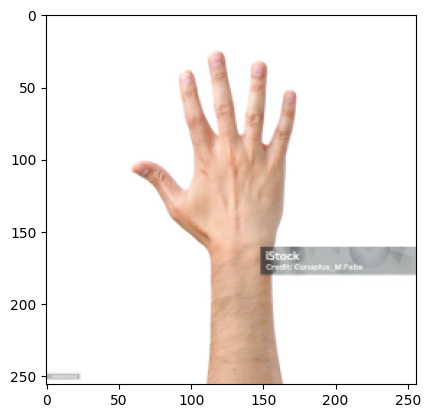

In [132]:
plt.imshow(X[0][3])


In [187]:
X_features = []

for i in range(len(X)):
    features = model_mobilenet.predict(X[i])
    X_features.append(features)

features.shape


1/1 [==============================] - 0s 93ms/step


(10, 1024)

In [219]:
X_features = tf.convert_to_tensor(X_features)
X_features.shape


TensorShape([2, 10, 1024])

### 4.2 Prepare y

In [235]:
# y = ["like", "like"]
y = [3, 1]
y = to_categorical(y, num_classes=20)
y.shape


(2, 20)

# 5. Train/val split

In [245]:
model.fit(
    X_features,
    y,
    # epochs=10,
    # batch_size=8,
    # validation_split=0.2,
    verbose=1
)


1/1 [==============================] - 0s 20ms/step - loss: 3.6837 - accuracy: 0.0000e+00


# 6. Evaluate